<a href="https://colab.research.google.com/github/ahmadagah/sentiment-llama/blob/main/notebooks/ahmad/sentiment_analysis_llama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %% SECTION 1
from __future__ import annotations

import time
import random
from typing import Optional

import numpy as np
import torch


# Safet Optimization for large-GPU environments.
# Long Training runs can cause CUDA memory fragmentaion, we avoid that by telling pytorch
# to create big flexible blocks "use expandable segments" or "larger continous chunks"
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"



# 1. Seeding, device, dtype
# ----------------------------------------------------------

def set_global_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_device() -> torch.device:
    """Return CUDA if available, else CPU."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_default_dtype(device: torch.device) -> torch.dtype:
    """Choose dtype based on hardware (BF16 if possible, else FP16/FP32)."""
    if device.type == "cuda":
        if torch.cuda.is_bf16_supported():
            return torch.bfloat16
        return torch.float16
    return torch.float32


# 2. timing + GPU memory
# ----------------------------------------------------------

# Global dictionary to store metrics per experiment name
resource_log: dict[str, dict[str, float]] = {}
# Internal state for the currently active monitor
_current_monitor: Optional[dict[str, float]] = None


def start_monitor(name: str) -> None:
    """Start tracking total time and peak GPU memory for this run."""
    global _current_monitor
    if _current_monitor is not None:
        raise RuntimeError("start_monitor() called while another monitor is active.")
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    _current_monitor = {"name": name, "start_time": time.time()}


def stop_monitor() -> None:
    """Stop tracking and store results in resource_log[name]."""
    global _current_monitor
    if _current_monitor is None:
        print("[monitor] WARNING: stop_monitor() called with no active monitor.")
        return

    name = _current_monitor["name"]
    start_time = _current_monitor["start_time"]
    total_time = time.time() - start_time

    if torch.cuda.is_available():
        # get the peak active tensor(GPU) memory since last reset
        peak_alloc_bytes = torch.cuda.max_memory_allocated()
    else:
        peak_alloc_bytes = 0

    gpu_peak_alloc_MB = float(peak_alloc_bytes) / (1024 ** 2)

    metrics = {
        "total_time_s": float(total_time),
        "gpu_peak_alloc_MB": gpu_peak_alloc_MB,
    }
    resource_log[name] = metrics

    print(
        f"[monitor] {name}: "
        f"total={total_time:.1f}s | gpu_peak={gpu_peak_alloc_MB:.1f} MB"
    )
    _current_monitor = None


class ResourceMonitor:
    """Context manager wrapper around start_monitor/stop_monitor."""

    def __init__(self, name: str):
        self.name = name

    def __enter__(self):
        start_monitor(self.name)
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        stop_monitor()
        return False


def print_resource_summary(log: dict[str, dict[str, float]]) -> None:
    """Print a short summary for all monitored runs."""
    if not log:
        print("print_resource_summary: log is empty.")
        return

    print("\n=== Resource Summary ===")
    for name, m in log.items():
        print(
            f"{name:15s} | "
            f"total={m['total_time_s']:.1f}s | "
            f"gpu_peak={m['gpu_peak_alloc_MB']:.1f} MB"
        )
    print("================================")


# 3. Model parameter stats
# ----------------------------------------------------------

def get_model_param_stats(model: torch.nn.Module) -> dict[str, float]:
    """Return basic stats for model weights (automatic dtype)."""
    params = list(model.parameters())
    if not params:
        return {
            "num_params": 0,
            "bytes_per_param": 0,
            "total_bytes": 0.0,
            "total_MB": 0.0,
        }

    # Read dtype directly from the model's parameters
    param_dtype = params[0].dtype
    num_params = sum(p.numel() for p in params)

    # Determine size of one element (2 bytes FP16/BF16, 4 bytes FP32)
    bytes_per_param = torch.tensor([], dtype=param_dtype).element_size()

    total_bytes = num_params * bytes_per_param
    total_MB = total_bytes / (1024 ** 2)

    return {
        "num_params": int(num_params),
        "bytes_per_param": int(bytes_per_param),
        "total_bytes": float(total_bytes),
        "total_MB": float(total_MB),
    }


def print_model_param_stats(model: torch.nn.Module) -> None:
    """Print number of parameters and weight memory."""
    stats = get_model_param_stats(model)
    print("=== Model Parameter Stats ===")
    print(f"Num parameters   : {stats['num_params']:,}")
    print(f"Bytes per param  : {stats['bytes_per_param']} bytes")
    print(f"Total weight mem : {stats['total_MB']:.2f} MB")
    print("=============================")


In [2]:
# %% SECTION 2 — Data for sentiment experiments (multiclass + binary)

from pathlib import Path
from collections import Counter

from datasets import (
    load_dataset,
    load_from_disk,
    DatasetDict,
    concatenate_datasets,
    Value,
)

# label spaces
label_names_multiclass = ["negative", "neutral", "positive"]
label_names_binary     = ["negative", "positive"]

# simple on-disk cache
DATA_CACHE_DIR = Path("sentiment_raw_cache")
DATA_CACHE_DIR.mkdir(exist_ok=True)


def _load_or_cache(name: str, builder):
    """Load dataset from local cache if present, else build and cache it."""
    path = DATA_CACHE_DIR / name
    if path.exists():
        print(f"[cache] {name}")
        return load_from_disk(path)
    print(f"[download] {name}")
    ds = builder()
    ds.save_to_disk(path)
    return ds


# ---------------------------------------------------------------------------
# 1. Load raw datasets
# ---------------------------------------------------------------------------

def _build_cardiff():
    base = (
        "https://huggingface.co/datasets/"
        "cardiffnlp/tweet_sentiment_multilingual/resolve/main/data/english"
    )
    files = {
        "train":      f"{base}/train.jsonl",
        "validation": f"{base}/validation.jsonl",
        "test":       f"{base}/test.jsonl",
    }
    return load_dataset("json", data_files=files)


cardiff_raw = _load_or_cache("cardiff_english", _build_cardiff)

tweet_raw = _load_or_cache(
    "tweet_eval_sentiment",
    lambda: load_dataset("tweet_eval", "sentiment"),
)

sent140_raw = _load_or_cache(
    "sentiment140",
    lambda: load_dataset(
        "parquet",
        data_files={
            "train": "https://huggingface.co/datasets/"
                     "stanfordnlp/sentiment140/resolve/refs%2Fconvert%2Fparquet/"
                     "sentiment140/train/0000.parquet",
            "test":  "https://huggingface.co/datasets/"
                     "stanfordnlp/sentiment140/resolve/refs%2Fconvert%2Fparquet/"
                     "sentiment140/test/0000.parquet",
        },
    ),
)

sst5_raw = _load_or_cache("sst5", lambda: load_dataset("SetFit/sst5"))
imdb_raw = _load_or_cache("imdb", lambda: load_dataset("imdb"))
yelp_raw = _load_or_cache("yelp_polarity", lambda: load_dataset("yelp_polarity"))

print("Raw datasets loaded.")


# ---------------------------------------------------------------------------
# 2. Labels
#    - multiclass: Cardiff, TweetEval, Sentiment140, SST-5
#    - binary    : IMDB, Yelp
# ---------------------------------------------------------------------------

# Cardiff & TweetEval: already 0=neg,1=neu,2=pos
cardiff_train = cardiff_raw["train"].cast_column("label", Value("int64"))
cardiff_val   = cardiff_raw["validation"].cast_column("label", Value("int64"))
cardiff_test  = cardiff_raw["test"].cast_column("label", Value("int64"))

tweet_train = tweet_raw["train"].cast_column("label", Value("int64"))
tweet_val   = tweet_raw["validation"].cast_column("label", Value("int64"))
tweet_test  = tweet_raw["test"].cast_column("label", Value("int64"))

# Sentiment140: 0=neg, 2=neu, 4=pos
cols_to_drop = [c for c in ["date", "query", "user"] if c in sent140_raw["train"].column_names]
if cols_to_drop:
    sent140_raw = sent140_raw.remove_columns(cols_to_drop)
if "sentiment" in sent140_raw["train"].column_names and "label" not in sent140_raw["train"].column_names:
    sent140_raw = sent140_raw.rename_column("sentiment", "label")


def _map_sent140(batch):
    batch["label"] = [0 if x == 0 else 1 if x == 2 else 2 for x in batch["label"]]
    return batch


sent140_proc = sent140_raw.map(_map_sent140, batched=True)
sent140_proc = sent140_proc.cast_column("label", Value("int64"))
sent140_train = sent140_proc["train"]
sent140_test  = sent140_proc["test"]

# SST-5: 0,1 -> neg(0); 2 -> neu(1); 3,4 -> pos(2)
sst5_train = sst5_raw["train"].cast_column("label", Value("int64"))
sst5_val   = sst5_raw["validation"].cast_column("label", Value("int64"))
sst5_test  = sst5_raw["test"].cast_column("label", Value("int64"))


def _map_sst5(batch):
    batch["label"] = [0 if x <= 1 else 1 if x == 2 else 2 for x in batch["label"]]
    return batch


sst5_train = sst5_train.map(_map_sst5, batched=True)
sst5_val   = sst5_val.map(_map_sst5, batched=True)
sst5_test  = sst5_test.map(_map_sst5, batched=True)

# Binary datasets (0/1)
imdb_train = imdb_raw["train"].cast_column("label", Value("int64"))
imdb_test  = imdb_raw["test"].cast_column("label", Value("int64"))
yelp_train = yelp_raw["train"].cast_column("label", Value("int64"))
yelp_test  = yelp_raw["test"].cast_column("label", Value("int64"))


# ---------------------------------------------------------------------------
# 3. Build merged train sets
# ---------------------------------------------------------------------------

# multiclass (3 labels)
train_multiclass = concatenate_datasets(
    [
        cardiff_train,
        cardiff_val,
        tweet_train,
        tweet_val,
        sent140_train,
        sst5_train,
        sst5_val,
    ]
)
train_data_multiclass = DatasetDict({"train": train_multiclass})

if "label_text" in train_data_multiclass["train"].column_names:
    train_data_multiclass = train_data_multiclass.remove_columns(["label_text"])

# binary (2 labels)
train_binary = concatenate_datasets([imdb_train, yelp_train])
train_data_binary = DatasetDict({"train": train_binary})

print("=== MULTICLASS TRAIN DATASET ===")
print(train_data_multiclass)
print("\n=== BINARY TRAIN DATASET ===")
print(train_data_binary)


# ---------------------------------------------------------------------------
# 4. Test sets
# ---------------------------------------------------------------------------

# per-dataset test sets
test_sets_multiclass = {
    "cardiff":      cardiff_test,
    "tweeteval":    tweet_test,
    "sentiment140": sent140_test,
    "sst5":         sst5_test,
}
combined_test_multiclass = concatenate_datasets(list(test_sets_multiclass.values()))
test_texts_multiclass  = combined_test_multiclass["text"]
test_labels_multiclass = combined_test_multiclass["label"]

test_sets_binary = {
    "imdb":          imdb_test,
    "yelp_polarity": yelp_test,
}
combined_test_binary = concatenate_datasets(list(test_sets_binary.values()))
test_texts_binary  = combined_test_binary["text"]
test_labels_binary = combined_test_binary["label"]

print("\n=== MULTICLASS TRAIN LABEL COUNTS ===")
c_multi = Counter(train_multiclass["label"])
print({label_names_multiclass[k]: c_multi.get(k, 0) for k in range(3)})

print("\n=== BINARY TRAIN LABEL COUNTS ===")
c_bin = Counter(train_binary["label"])
print({label_names_binary[k]: c_bin.get(k, 0) for k in range(2)})


[download] cardiff_english


data/english/train.jsonl:   0%|          | 0.00/253k [00:00<?, ?B/s]

data/english/validation.jsonl:   0%|          | 0.00/44.5k [00:00<?, ?B/s]

data/english/test.jsonl:   0%|          | 0.00/107k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1839 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/324 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/870 [00:00<?, ? examples/s]

[download] tweet_eval_sentiment


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/45615 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

[download] sentiment140


sentiment140/train/0000.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/46.1k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1600000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/498 [00:00<?, ? examples/s]

[download] sst5


README.md:   0%|          | 0.00/421 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl: 0.00B [00:00, ?B/s]

dev.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8544 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1101 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2210 [00:00<?, ? examples/s]

[download] imdb


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

[download] yelp_polarity


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/560000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/38000 [00:00<?, ? examples/s]

Raw datasets loaded.


Casting the dataset:   0%|          | 0/1839 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/324 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/870 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/45615 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/498 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/8544 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1101 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2210 [00:00<?, ? examples/s]

Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/25000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/25000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/560000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/38000 [00:00<?, ? examples/s]

=== MULTICLASS TRAIN DATASET ===
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1659423
    })
})

=== BINARY TRAIN DATASET ===
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 585000
    })
})

=== MULTICLASS TRAIN LABEL COUNTS ===
{'negative': 811864, 'neutral': 24116, 'positive': 823443}

=== BINARY TRAIN LABEL COUNTS ===
{'negative': 292500, 'positive': 292500}


In [3]:
# %% SECTION 3 DATASET SUMMARY TABLE

import pandas as pd

data_summary = [
    {
        "Dataset": "CardiffNLP",
        "Type": "3-way sentiment",
        "Train Size": cardiff_train.num_rows,
        "Validation Size": cardiff_val.num_rows,
        "Test Size": cardiff_test.num_rows,
        "Notes": "Small English tweets",
    },
    {
        "Dataset": "TweetEval",
        "Type": "3-way sentiment",
        "Train Size": tweet_train.num_rows,
        "Validation Size": tweet_val.num_rows,
        "Test Size": tweet_test.num_rows,
        "Notes": "Large Twitter benchmark",
    },
    {
        "Dataset": "Sentiment140",
        "Type": "3-way sentiment",
        "Train Size": sent140_train.num_rows,
        "Validation Size": "—",
        "Test Size": sent140_test.num_rows,
        "Notes": "Very large",
    },
    {
        "Dataset": "SST-5",
        "Type": "Fine-grained (5→3 classes)",
        "Train Size": sst5_train.num_rows,
        "Validation Size": sst5_val.num_rows,
        "Test Size": sst5_test.num_rows,
        "Notes": "Movie review phrases",
    },
    {
        "Dataset": "IMDB",
        "Type": "Binary sentiment",
        "Train Size": imdb_train.num_rows,
        "Validation Size": "—",
        "Test Size": imdb_test.num_rows,
        "Notes": "Long movie reviews",
    },
    {
        "Dataset": "Yelp Polarity",
        "Type": "Binary sentiment",
        "Train Size": yelp_train.num_rows,
        "Validation Size": "—",
        "Test Size": yelp_test.num_rows,
        "Notes": "Large customer reviews",
    },
]

df_summary = pd.DataFrame(data_summary)
df_summary


,Dataset,Type,Train Size,Validation Size,Test Size,Notes
0,CardiffNLP,3-way sentiment,1839,324,870,Small English tweets
1,TweetEval,3-way sentiment,45615,2000,12284,Large Twitter benchmark
2,Sentiment140,3-way sentiment,1600000,—,498,Very large
3,SST-5,Fine-grained (5→3 classes),8544,1101,2210,Movie review phrases
4,IMDB,Binary sentiment,25000,—,25000,Long movie reviews
5,Yelp Polarity,Binary sentiment,560000,—,38000,Large customer reviews


In [4]:
# SECTION 4 — Base model, tokenizer, generation pipeline

!pip install -q transformers

from google.colab import userdata
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

MODEL_ID = "meta-llama/Llama-3.2-1B-Instruct"


def _get_hf_token() -> str:
    token = userdata.get("HF_TOKEN")
    if not token:
        raise RuntimeError("HF_TOKEN not set in Colab userdata.")
    return token


def load_llama_classifier(
    model_id: str = MODEL_ID,
    hf_token: str | None = None,
):
    if hf_token is None:
        hf_token = _get_hf_token()

    tok = AutoTokenizer.from_pretrained(model_id, token=hf_token)

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        torch_dtype="auto",
        token=hf_token,
    )

    gen = pipeline("text-generation", model=model, tokenizer=tok)
    gen.generation_config = GenerationConfig(
        do_sample=False,
        max_new_tokens=1,
        eos_token_id=tok.eos_token_id,
        pad_token_id=tok.eos_token_id,
    )

    return tok, model, gen


tok, model, gen = load_llama_classifier()
print_model_param_stats(model)
print("Loaded on:", next(model.parameters()).device)


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cuda:0


=== Model Parameter Stats ===
Num parameters   : 1,235,814,400
Bytes per param  : 2 bytes
Total weight mem : 2357.13 MB
Loaded on: cuda:0


In [5]:
# %% SECTION 5 — Shared helpers (training + inference)

!pip install -q tqdm scikit-learn

import re
from typing import Dict, List, Callable, Sequence

import torch
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizerBase, TrainerCallback

from tqdm.auto import tqdm
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt


from transformers.utils import logging as hf_logging
hf_logging.set_verbosity_error()

# 4.1 Supervised LM data for IA-3
_LABEL_WORDS = {
    "negative": "Negative",
    "neutral": "Neutral",
    "positive": "Positive",
}

def make_sup_lm_data(
    tokenizer: PreTrainedTokenizerBase,
    ds_train,
    label_names: Sequence[str],
    prompt_builder: Callable[[str], str] | None = None,
    max_length: int = 160,
):
    if prompt_builder is None:
        def default_prompt_builder(tweet: str) -> str:
            return (
                "Task: Determine sentiment polarity.\n"
                "Output must be a single word label.\n"
                "Valid outputs: Neutral, Positive, Negative.\n"
                f'Input: "{tweet}"\n'
                "Label:"
            )
        prompt_builder = default_prompt_builder

    def first_label_token_id(tok: PreTrainedTokenizerBase, word: str) -> int:
        ids = tok.encode(" " + word, add_special_tokens=False)
        return ids[0]

    LABEL2TOK: Dict[str, int] = {}
    for lbl in label_names:
        if lbl not in _LABEL_WORDS:
            raise ValueError(f"Unknown label '{lbl}'. Expected subset of {_LABEL_WORDS.keys()}.")
        LABEL2TOK[lbl] = first_label_token_id(tokenizer, _LABEL_WORDS[lbl])

    def build_sup_ids(tweet_text: str, gold_label: str) -> Dict[str, List[int]]:
        prompt = prompt_builder(tweet_text)
        prompt_ids = tokenizer.encode(prompt, add_special_tokens=False)
        label_id = LABEL2TOK[gold_label]

        input_ids = prompt_ids + [label_id]
        attention_mask = [1] * len(input_ids)
        labels = [-100] * len(prompt_ids) + [label_id]

        if len(input_ids) > max_length:
            input_ids = input_ids[-max_length:]
            attention_mask = attention_mask[-max_length:]
            labels = labels[-max_length:]

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

    class SupLMDataset(Dataset):
        def __init__(self, texts: List[str], labels: List[int]):
            self.examples = []
            for t, y_idx in zip(texts, labels):
                gold_name = label_names[int(y_idx)]
                ex = build_sup_ids(t, gold_name)
                self.examples.append(ex)

        def __len__(self) -> int:
            return len(self.examples)

        def __getitem__(self, idx: int) -> Dict[str, List[int]]:
            return self.examples[idx]

    def pad_collate(batch):
        if tokenizer.pad_token_id is None:
            tokenizer.pad_token = tokenizer.eos_token
        pad_id = tokenizer.pad_token_id

        max_len = max(len(x["input_ids"]) for x in batch)
        input_ids, attn, labels = [], [], []

        for x in batch:
            pad_len = max_len - len(x["input_ids"])
            input_ids.append(x["input_ids"] + [pad_id] * pad_len)
            attn.append(x["attention_mask"] + [0] * pad_len)
            labels.append(x["labels"] + [-100] * pad_len)

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attn, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }

    train_texts = [row["text"] for row in ds_train]
    train_labels = [row["label"] for row in ds_train]

    train_ds = SupLMDataset(train_texts, train_labels)
    return train_ds, pad_collate, LABEL2TOK


class EtaCallback(TrainerCallback):
    def __init__(self, total_steps: int, print_every: int = 50):
        self.total_steps = total_steps
        self.print_every = print_every
        self.start_time = None

    def on_train_begin(self, args, state, control, **kwargs):
        import time
        self.start_time = time.time()
        print(f"[ETA] Training started — total steps: {self.total_steps}")

    def on_step_end(self, args, state, control, **kwargs):
        import time

        step = state.global_step
        if step == 0 or (step % self.print_every != 0):
            return

        elapsed = time.time() - self.start_time
        avg_step = elapsed / step
        remaining = max(0.0, avg_step * (self.total_steps - step))

        def fmt(sec: float) -> str:
            sec = int(sec)
            m, s = divmod(sec, 60)
            h, m = divmod(m, 60)
            return f"{h:02d}:{m:02d}:{s:02d}"

        loss_str = "N/A"
        try:
            if state.log_history:
                last_log = state.log_history[-1]
                if "loss" in last_log:
                    loss_str = f"{last_log['loss']:.4f}"
        except Exception:
            pass

        pct = 100.0 * step / self.total_steps
        print(
            f"[ETA] step {step}/{self.total_steps} ({pct:.1f}%) | "
            f"loss {loss_str} | elapsed {fmt(elapsed)} | remaining ~{fmt(remaining)}"
        )

# 4.2 Label parsing (3-way / binary)
ANS_RE_3WAY = re.compile(r"\b(positive|neutral|negative)\b", re.I)
ANS_RE_BINARY = re.compile(r"\b(positive|negative)\b", re.I)

def parse_label_3way(text: str) -> str:
    m = ANS_RE_3WAY.search(text)
    return m.group(1).lower() if m else "neutral"

def parse_label_binary(text: str) -> str:
    m = ANS_RE_BINARY.search(text)
    return m.group(1).lower() if m else "negative"

CURRENT_PARSE_FN = parse_label_3way  # will be set before each experiment

# 4.3 Core prediction helper
def predict_texts(
    gen,
    texts: List[str],
    prompt_builder: Callable[[str], str],
    batch_size: int = 128,
    show_progress: bool = True,
) -> List[str]:
    prompts = [prompt_builder(t) for t in texts]
    preds: List[str] = []

    index_range = range(0, len(prompts), batch_size)
    if show_progress:
        index_range = tqdm(index_range, desc="Eval", unit="batch")

    with torch.inference_mode():
        for i in index_range:
            batch = prompts[i: i + batch_size]
            outputs = gen(batch, return_full_text=False, num_return_sequences=1)
            for seqs in outputs:
                out_text = seqs[0]["generated_text"]
                preds.append(CURRENT_PARSE_FN(out_text))

    return preds

# 4.4 Reporting + confusion matrix
def print_report(
    title: str,
    y_true: List[str],
    y_pred: List[str],
    label_names: List[str],
) -> None:
    print(f"\n{title}\n")
    print(classification_report(y_true, y_pred, labels=label_names, digits=3))

def plot_confusion_matrix_simple(
    title: str,
    y_true: List[str],
    y_pred: List[str],
    label_names: List[str],
):
    cm = confusion_matrix(y_true, y_pred, labels=label_names)
    fig, ax = plt.subplots(figsize=(4, 3))
    im = ax.imshow(cm, aspect="auto")

    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks(range(len(label_names)))
    ax.set_yticks(range(len(label_names)))
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)

    for i in range(len(label_names)):
        for j in range(len(label_names)):
            ax.text(j, i, cm[i, j], ha="center", va="center")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def summarize_experiment(
    name: str,
    y_true: list,
    y_pred: list,
    label_names: list[str],
    weight_MB: float | None = None,
    show_cm: bool = True,
    title: str | None = None,
):
    def _to_str_labels(labels):
        if not labels:
            return labels
        first = labels[0]
        if isinstance(first, int):
            return [label_names[i] for i in labels]
        return labels

    y_true_str = _to_str_labels(y_true)
    y_pred_str = _to_str_labels(y_pred)
    n = len(y_true_str)

    print_report(f"{name.upper()} RESULTS", y_true_str, y_pred_str, label_names)

    acc = accuracy_score(y_true_str, y_pred_str)
    macro = f1_score(y_true_str, y_pred_str, average="macro")
    print(f"\n{name} — Accuracy: {acc:.3f} | Macro-F1: {macro:.3f} | N={n}")

    if show_cm:
        plot_confusion_matrix_simple(
            title=title or f"Confusion Matrix — {name} (N={n})",
            y_true=y_true_str,
            y_pred=y_pred_str,
            label_names=label_names,
        )

    return {"accuracy": acc, "macro_f1": macro, "N": n}

# 4.5 Zero-shot prompts
def zero_shot_prompt_3way(tweet: str) -> str:
    return (
        "Task: Determine sentiment polarity.\n"
        "Output must be a single word label.\n"
        "Valid outputs: Neutral, Positive, Negative.\n"
        f'Input: "{tweet}"\n'
        "Label:"
    )

def zero_shot_prompt_binary(tweet: str) -> str:
    return (
        "Task: Determine sentiment polarity.\n"
        "Output must be a single word label.\n"
        "Valid outputs: Negative, Positive.\n"
        f'Input: "{tweet}"\n'
        "Label:"
    )


In [6]:
# %% SECTION 6.0 — Shared sampling helper (train + test)

from datasets import concatenate_datasets

def build_sampled_split(
    datasets_dict: dict,
    config: dict,
    seed: int,
    track_name: str,
    max_total: int | None = None,
):

    if not config:
        raise ValueError(f"[{track_name}] config dict is empty; select at least one dataset.")

    selected_splits = []
    used_info = []

    # how many examples we can still add globally
    remaining = None if max_total is None else int(max_total)

    for name, cfg_val in config.items():
        if name not in datasets_dict:
            raise ValueError(
                f"[{track_name}] Unknown dataset '{name}'. "
                f"Available: {list(datasets_dict.keys())}"
            )

        ds = datasets_dict[name]
        n_total = ds.num_rows

        # decide local limit for this dataset
        if cfg_val is None:
            per_limit = n_total           # all
        else:
            per_limit = int(cfg_val)
            if per_limit < 0:
                per_limit = 0             # negative -> treated as 0

        if per_limit == 0:
            used_info.append((name, 0, n_total))
            continue                      # skip this dataset

        # obey global cap if we have one
        if remaining is not None:
            if remaining <= 0:
                used_info.append((name, 0, n_total))
                continue
            per_limit = min(per_limit, remaining)
            remaining -= per_limit

        # don't ask for more rows than exist
        per_limit = min(per_limit, n_total)

        if per_limit <= 0:
            used_info.append((name, 0, n_total))
            continue

        ds_sel = ds.shuffle(seed=seed).select(range(per_limit))
        selected_splits.append(ds_sel)
        used_info.append((name, per_limit, n_total))

    if not selected_splits:
        raise ValueError(f"[{track_name}] No datasets selected after processing config.")

    combined = concatenate_datasets(selected_splits)
    return combined, used_info



===== Running 3-way zero-shot experiment: zero_shot_3way =====
Train examples (3-way): 1659423
TOTAL test examples (3-way, after sampling): 15862
Per-dataset selection (3-way):
  - cardiff: 870 / 870 examples
  - tweeteval: 12284 / 12284 examples
  - sentiment140: 498 / 498 examples
  - sst5: 2210 / 2210 examples


Eval:   0%|          | 0/124 [00:00<?, ?batch/s]

[monitor] zero_shot_3way: total=326.9s | gpu_peak=4731.3 MB

--- 3-way per-dataset: cardiff (N=870) ---

ZERO_SHOT_3WAY_CARDIFF RESULTS

              precision    recall  f1-score   support

    negative      0.744     0.562     0.640       290
     neutral      0.506     0.286     0.366       290
    positive      0.546     0.917     0.685       290

    accuracy                          0.589       870
   macro avg      0.599     0.589     0.564       870
weighted avg      0.599     0.589     0.564       870


zero_shot_3way_cardiff — Accuracy: 0.589 | Macro-F1: 0.564 | N=870


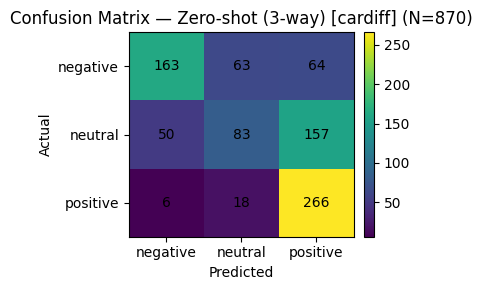


--- 3-way per-dataset: tweeteval (N=12284) ---

ZERO_SHOT_3WAY_TWEETEVAL RESULTS

              precision    recall  f1-score   support

    negative      0.713     0.510     0.595      3972
     neutral      0.618     0.274     0.379      5937
    positive      0.318     0.912     0.472      2375

    accuracy                          0.474     12284
   macro avg      0.550     0.565     0.482     12284
weighted avg      0.591     0.474     0.467     12284


zero_shot_3way_tweeteval — Accuracy: 0.474 | Macro-F1: 0.482 | N=12284


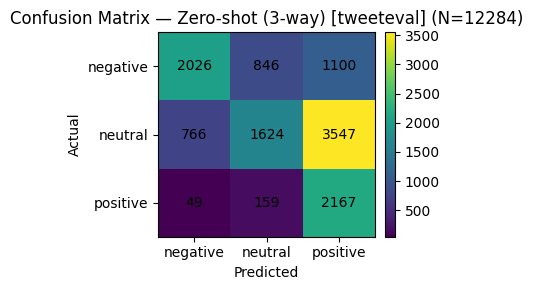


--- 3-way per-dataset: sentiment140 (N=498) ---

ZERO_SHOT_3WAY_SENTIMENT140 RESULTS

              precision    recall  f1-score   support

    negative      0.885     0.520     0.655       177
     neutral      0.413     0.137     0.205       139
    positive      0.483     0.923     0.634       182

    accuracy                          0.560       498
   macro avg      0.593     0.527     0.498       498
weighted avg      0.606     0.560     0.522       498


zero_shot_3way_sentiment140 — Accuracy: 0.560 | Macro-F1: 0.498 | N=498


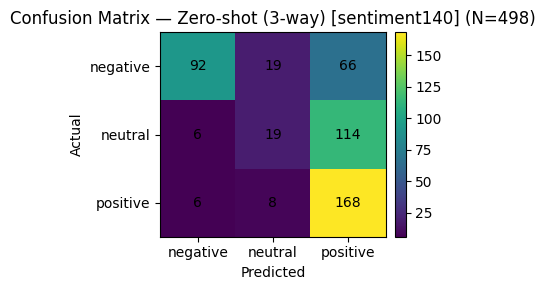


--- 3-way per-dataset: sst5 (N=2210) ---

ZERO_SHOT_3WAY_SST5 RESULTS

              precision    recall  f1-score   support

    negative      0.831     0.538     0.653       912
     neutral      0.242     0.198     0.218       389
    positive      0.636     0.910     0.748       909

    accuracy                          0.631      2210
   macro avg      0.570     0.549     0.540      2210
weighted avg      0.647     0.631     0.616      2210


zero_shot_3way_sst5 — Accuracy: 0.631 | Macro-F1: 0.540 | N=2210


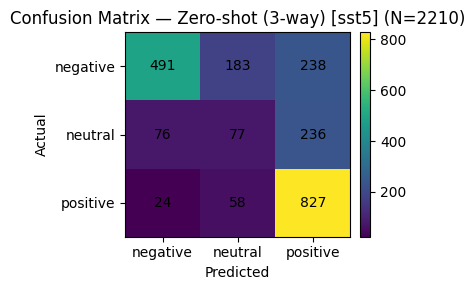


--- 3-way combined (all selected datasets) (N=15862) ---

ZERO_SHOT_3WAY RESULTS

              precision    recall  f1-score   support

    negative      0.738     0.518     0.609      5351
     neutral      0.571     0.267     0.364      6755
    positive      0.383     0.913     0.540      3756

    accuracy                          0.505     15862
   macro avg      0.564     0.566     0.504     15862
weighted avg      0.583     0.505     0.488     15862


zero_shot_3way — Accuracy: 0.505 | Macro-F1: 0.504 | N=15862


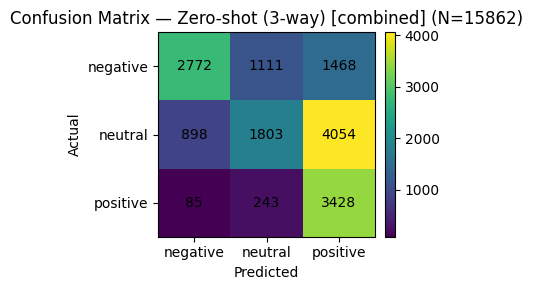

In [ ]:
# %% SECTION 7 — Zero-shot baseline (3-way sentiment)

GLOBAL_SEED = 42
set_global_seed(GLOBAL_SEED)

ZS3_TEST_CONFIG = {
    "cardiff":      None,   # all
    "tweeteval":    None,
    "sentiment140": None,
    "sst5":         None,
}
ZS3_MAX_TEST = None    # or an int for global cap, e.g. 5000
ZS3_SEED = GLOBAL_SEED

ds_train_multi = train_data_multiclass["train"]
label_names_3 = label_names_multiclass
test_datasets_3way = test_sets_multiclass

combined_test_3way_sel, used_datasets_3way = build_sampled_split(
    datasets_dict=test_datasets_3way,
    config=ZS3_TEST_CONFIG,
    seed=ZS3_SEED,
    track_name="3-way-test",
    max_total=ZS3_MAX_TEST,
)

all_texts_3way = combined_test_3way_sel["text"]
all_labels_3way = combined_test_3way_sel["label"]

CURRENT_PARSE_FN = parse_label_3way
EXPERIMENT_NAME_ZS_3WAY = "zero_shot_3way"

print(f"\n===== Running 3-way zero-shot experiment: {EXPERIMENT_NAME_ZS_3WAY} =====")
print("Train examples (3-way):", len(ds_train_multi))
print("TOTAL test examples (3-way, after sampling):", len(all_texts_3way))
print("Per-dataset selection (3-way):")
for name, n_sel, n_total in used_datasets_3way:
    print(f"  - {name}: {n_sel} / {n_total} examples")

tok_zs_3, model_zs_3, gen_zs_3 = load_llama_classifier()

with ResourceMonitor(EXPERIMENT_NAME_ZS_3WAY):
    preds_all_3way = predict_texts(
        gen=gen_zs_3,
        texts=all_texts_3way,
        prompt_builder=zero_shot_prompt_3way,
        batch_size=128,
        show_progress=True,
    )

per_dataset_3way_metrics = {}
offset = 0

for name, n_sel, n_total in used_datasets_3way:
    start = offset
    end = offset + n_sel
    offset = end

    y_true_ds = all_labels_3way[start:end]
    y_pred_ds = preds_all_3way[start:end]

    print(f"\n--- 3-way per-dataset: {name} (N={n_sel}) ---")
    title_ds = f"Confusion Matrix — Zero-shot (3-way) [{name}] (N={n_sel})"

    m_ds = summarize_experiment(
        name=f"{EXPERIMENT_NAME_ZS_3WAY}_{name}",
        y_true=y_true_ds,
        y_pred=y_pred_ds,
        label_names=label_names_3,
        weight_MB=None,
        show_cm=True,
        title=title_ds,
    )
    per_dataset_3way_metrics[name] = m_ds

print(f"\n--- 3-way combined (all selected datasets) (N={len(all_labels_3way)}) ---")
title_all = f"Confusion Matrix — Zero-shot (3-way) [combined] (N={len(all_labels_3way)})"

zero_shot_3way_metrics = summarize_experiment(
    name=EXPERIMENT_NAME_ZS_3WAY,
    y_true=all_labels_3way,
    y_pred=preds_all_3way,
    label_names=label_names_3,
    weight_MB=None,
    show_cm=True,
    title=title_all,
)

ZS3_N_EVAL = len(all_labels_3way)

del model_zs_3
if torch.cuda.is_available():
    torch.cuda.empty_cache()



===== Running binary zero-shot experiment: zero_shot_binary =====
Train examples (binary): 585000
TOTAL test examples (binary, after sampling): 63000
Per-dataset selection (binary):
  - imdb: 25000 / 25000 examples
  - yelp_polarity: 38000 / 38000 examples


Eval:   0%|          | 0/493 [00:00<?, ?batch/s]

[monitor] zero_shot_binary: total=1342.1s | gpu_peak=7356.4 MB

--- Binary per-dataset: imdb (N=25000) ---

ZERO_SHOT_BINARY_IMDB RESULTS

              precision    recall  f1-score   support

    negative      0.952     0.442     0.603     12500
    positive      0.636     0.978     0.771     12500

    accuracy                          0.710     25000
   macro avg      0.794     0.710     0.687     25000
weighted avg      0.794     0.710     0.687     25000


zero_shot_binary_imdb — Accuracy: 0.710 | Macro-F1: 0.687 | N=25000


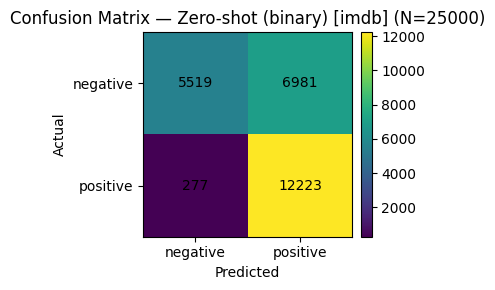


--- Binary per-dataset: yelp_polarity (N=38000) ---

ZERO_SHOT_BINARY_YELP_POLARITY RESULTS

              precision    recall  f1-score   support

    negative      0.984     0.670     0.797     19000
    positive      0.750     0.989     0.853     19000

    accuracy                          0.830     38000
   macro avg      0.867     0.830     0.825     38000
weighted avg      0.867     0.830     0.825     38000


zero_shot_binary_yelp_polarity — Accuracy: 0.830 | Macro-F1: 0.825 | N=38000


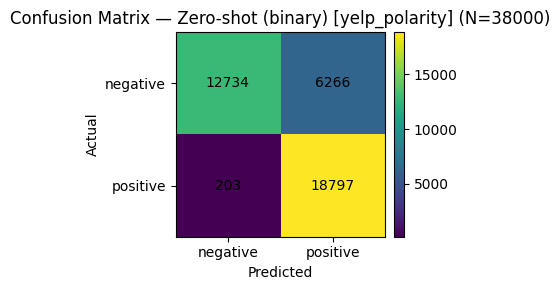


--- Binary combined (all selected datasets) (N=63000) ---

ZERO_SHOT_BINARY RESULTS

              precision    recall  f1-score   support

    negative      0.974     0.579     0.727     31500
    positive      0.701     0.985     0.819     31500

    accuracy                          0.782     63000
   macro avg      0.838     0.782     0.773     63000
weighted avg      0.838     0.782     0.773     63000


zero_shot_binary — Accuracy: 0.782 | Macro-F1: 0.773 | N=63000


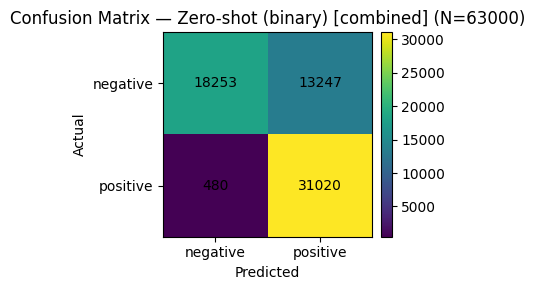

In [ ]:
# %% SECTION 8 — Zero-shot baseline (binary sentiment)

ZSBIN_TEST_CONFIG = {
    "imdb":          None,
    "yelp_polarity": None,
}
ZSBIN_MAX_TEST = None
ZSBIN_SEED = GLOBAL_SEED + 1

ds_train_bin = train_data_binary["train"]
label_names_2 = label_names_binary
test_datasets_binary = test_sets_binary

combined_test_binary_sel, used_datasets_bin = build_sampled_split(
    datasets_dict=test_datasets_binary,
    config=ZSBIN_TEST_CONFIG,
    seed=ZSBIN_SEED,
    track_name="binary-test",
    max_total=ZSBIN_MAX_TEST,
)

all_texts_bin = combined_test_binary_sel["text"]
all_labels_bin = combined_test_binary_sel["label"]

CURRENT_PARSE_FN = parse_label_binary
EXPERIMENT_NAME_ZS_BIN = "zero_shot_binary"

print(f"\n===== Running binary zero-shot experiment: {EXPERIMENT_NAME_ZS_BIN} =====")
print("Train examples (binary):", len(ds_train_bin))
print("TOTAL test examples (binary, after sampling):", len(all_texts_bin))
print("Per-dataset selection (binary):")
for name, n_sel, n_total in used_datasets_bin:
    print(f"  - {name}: {n_sel} / {n_total} examples")

tok_zs_b, model_zs_b, gen_zs_b = load_llama_classifier()

with ResourceMonitor(EXPERIMENT_NAME_ZS_BIN):
    preds_all_bin = predict_texts(
        gen=gen_zs_b,
        texts=all_texts_bin,
        prompt_builder=zero_shot_prompt_binary,
        batch_size=128,
        show_progress=True,
    )

per_dataset_binary_metrics = {}
offset = 0

for name, n_sel, n_total in used_datasets_bin:
    start = offset
    end = offset + n_sel
    offset = end

    y_true_ds = all_labels_bin[start:end]
    y_pred_ds = preds_all_bin[start:end]

    print(f"\n--- Binary per-dataset: {name} (N={n_sel}) ---")
    title_ds = f"Confusion Matrix — Zero-shot (binary) [{name}] (N={n_sel})"

    m_ds = summarize_experiment(
        name=f"{EXPERIMENT_NAME_ZS_BIN}_{name}",
        y_true=y_true_ds,
        y_pred=y_pred_ds,
        label_names=label_names_2,
        weight_MB=None,
        show_cm=True,
        title=title_ds,
    )
    per_dataset_binary_metrics[name] = m_ds

print(f"\n--- Binary combined (all selected datasets) (N={len(all_labels_bin)}) ---")
title_all = f"Confusion Matrix — Zero-shot (binary) [combined] (N={len(all_labels_bin)})"

zero_shot_binary_metrics = summarize_experiment(
    name=EXPERIMENT_NAME_ZS_BIN,
    y_true=all_labels_bin,
    y_pred=preds_all_bin,
    label_names=label_names_2,
    weight_MB=None,
    show_cm=True,
    title=title_all,
)

ZSBIN_N_EVAL = len(all_labels_bin)

del model_zs_b
if torch.cuda.is_available():
    torch.cuda.empty_cache()


In [ ]:
# %% SECTION 9 — Combined zero-shot summary (3-way + binary)

acc_3 = zero_shot_3way_metrics["accuracy"]
acc_2 = zero_shot_binary_metrics["accuracy"]

combined_acc = (acc_3 * ZS3_N_EVAL + acc_2 * ZSBIN_N_EVAL) / float(ZS3_N_EVAL + ZSBIN_N_EVAL)

print("\n=== Zero-shot Overall (3-way + binary) ===")
print(f"Zero-shot (3-way)   accuracy: {acc_3:.4f}  (N={ZS3_N_EVAL})")
print(f"Zero-shot (binary)  accuracy: {acc_2:.4f}  (N={ZSBIN_N_EVAL})")
print(f"Combined micro accuracy:      {combined_acc:.4f}  (N={ZS3_N_EVAL + ZSBIN_N_EVAL})")



=== Zero-shot Overall (3-way + binary) ===
Zero-shot (3-way)   accuracy: 0.5045  (N=15862)
Zero-shot (binary)  accuracy: 0.7821  (N=63000)
Combined micro accuracy:      0.7263  (N=78862)



[ia3_3way] Building TRAIN split...
[ia3_3way] Train selection:
  - cardiff: 2163 / 2163 examples
  - tweeteval: 47615 / 47615 examples
  - sentiment140: 300000 / 1600000 examples
  - sst5: 9645 / 9645 examples
[ia3_3way] TOTAL train examples: 359423
[ia3_3way] Building TEST split...
[ia3_3way] TOTAL test examples: 15862
[ia3_3way] Loading tokenizer and base model (this can take a while)...
[ia3_3way] Model loaded.
[ia3_3way] Building supervised LM dataset...
[ia3_3way] Train dataset ready: 359423 examples.
[ia3_3way] Attaching IA-3 adapters...
trainable params: 278,528 || all params: 1,236,092,928 || trainable%: 0.0225
[ia3_3way] IA-3 weight memory [MB]: 4715.32
[ia3_3way] Training setup: 3 epochs, ~5502 steps.
[ia3_3way] Starting training...


/tmp/ipython-input-4024919938.py:254: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[ia3_3way] Step 50/5502 (0.9%)
{'loss': 0.8271, 'grad_norm': 0.34723445773124695, 'learning_rate': 9.910941475826972e-05, 'epoch': 0.027262813522355506}
[ia3_3way] Step 100/5502 (1.8%)
{'loss': 0.6448, 'grad_norm': 0.4211227595806122, 'learning_rate': 9.820065430752454e-05, 'epoch': 0.05452562704471101}
[ia3_3way] Step 150/5502 (2.7%)
{'loss': 0.6097, 'grad_norm': 0.3092224895954132, 'learning_rate': 9.729189385677937e-05, 'epoch': 0.08178844056706652}
[ia3_3way] Step 200/5502 (3.6%)
{'loss': 0.5859, 'grad_norm': 0.42469462752342224, 'learning_rate': 9.638313340603417e-05, 'epoch': 0.10905125408942203}
[ia3_3way] Step 250/5502 (4.5%)
{'loss': 0.5657, 'grad_norm': 0.5780395865440369, 'learning_rate': 9.5474372955289e-05, 'epoch': 0.13631406761177753}
[ia3_3way] Step 300/5502 (5.5%)
{'loss': 0.5384, 'grad_norm': 0.6883761882781982, 'learning_rate': 9.456561250454382e-05, 'epoch': 0.16357688113413305}
[ia3_3way] Step 350/5502 (6.4%)
{'loss': 0.5228, 'grad_norm': 0.47650057077407837, 'lear

Eval:   0%|          | 0/124 [00:00<?, ?batch/s]

[monitor] ia3_3way_eval: total=484.0s | gpu_peak=7108.7 MB
[ia3_3way] Evaluation finished.

IA3_3WAY_CARDIFF RESULTS

              precision    recall  f1-score   support

    negative      0.605     0.914     0.728       290
     neutral      0.620     0.259     0.365       290
    positive      0.730     0.783     0.755       290

    accuracy                          0.652       870
   macro avg      0.652     0.652     0.616       870
weighted avg      0.652     0.652     0.616       870


ia3_3way_cardiff — Accuracy: 0.652 | Macro-F1: 0.616 | N=870


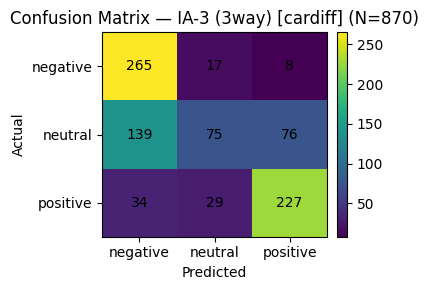


IA3_3WAY_TWEETEVAL RESULTS

              precision    recall  f1-score   support

    negative      0.631     0.801     0.706      3972
     neutral      0.732     0.549     0.628      5937
    positive      0.615     0.722     0.664      2375

    accuracy                          0.664     12284
   macro avg      0.660     0.691     0.666     12284
weighted avg      0.677     0.664     0.660     12284


ia3_3way_tweeteval — Accuracy: 0.664 | Macro-F1: 0.666 | N=12284


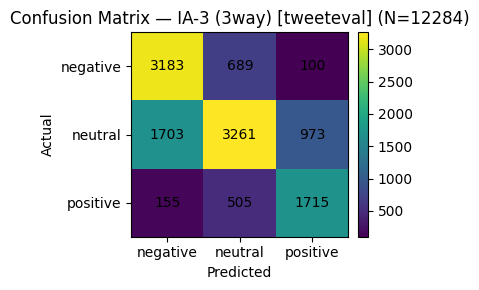


IA3_3WAY_SENTIMENT140 RESULTS

              precision    recall  f1-score   support

    negative      0.827     0.944     0.881       177
     neutral      0.815     0.381     0.520       139
    positive      0.671     0.852     0.751       182

    accuracy                          0.753       498
   macro avg      0.771     0.725     0.717       498
weighted avg      0.767     0.753     0.733       498


ia3_3way_sentiment140 — Accuracy: 0.753 | Macro-F1: 0.717 | N=498


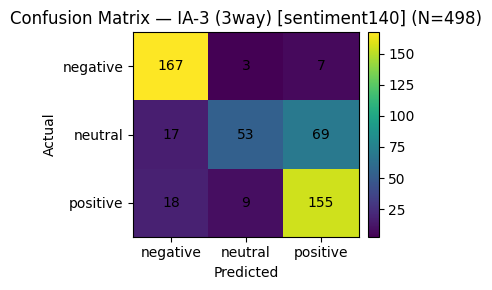


IA3_3WAY_SST5 RESULTS

              precision    recall  f1-score   support

    negative      0.734     0.879     0.800       912
     neutral      0.341     0.275     0.304       389
    positive      0.884     0.781     0.829       909

    accuracy                          0.733      2210
   macro avg      0.653     0.645     0.645      2210
weighted avg      0.726     0.733     0.725      2210


ia3_3way_sst5 — Accuracy: 0.733 | Macro-F1: 0.645 | N=2210


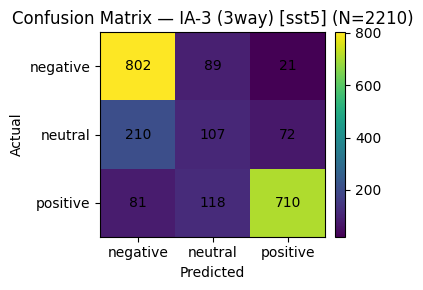


IA3_3WAY RESULTS

              precision    recall  f1-score   support

    negative      0.652     0.825     0.729      5351
     neutral      0.706     0.518     0.597      6755
    positive      0.679     0.747     0.712      3756

    accuracy                          0.676     15862
   macro avg      0.679     0.697     0.679     15862
weighted avg      0.681     0.676     0.669     15862


ia3_3way — Accuracy: 0.676 | Macro-F1: 0.679 | N=15862


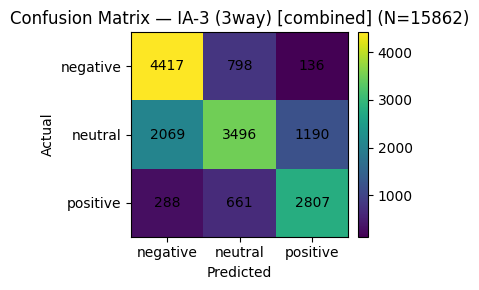

[ia3_3way] Cleaning up GPU memory...
[ia3_3way] Done.


[ia3_binary] Building TRAIN split...
[ia3_binary] Train selection:
  - imdb: 25000 / 25000 examples
  - yelp_polarity: 560000 / 560000 examples
[ia3_binary] TOTAL train examples: 585000
[ia3_binary] Building TEST split...
[ia3_binary] TOTAL test examples: 63000
[ia3_binary] Loading tokenizer and base model (this can take a while)...
[ia3_binary] Model loaded.
[ia3_binary] Building supervised LM dataset...
[ia3_binary] Train dataset ready: 585000 examples.
[ia3_binary] Attaching IA-3 adapters...
trainable params: 278,528 || all params: 1,236,092,928 || trainable%: 0.0225
[ia3_binary] IA-3 weight memory [MB]: 4715.32
[ia3_binary] Training setup: 3 epochs, ~8955 steps.
[ia3_binary] Starting training...


/tmp/ipython-input-4024919938.py:254: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[ia3_binary] Step 50/8955 (0.6%)
{'loss': 1.9248, 'grad_norm': 1.2299426794052124, 'learning_rate': 9.945281965382468e-05, 'epoch': 0.01675041876046901}
[ia3_binary] Step 100/8955 (1.1%)
{'loss': 0.3092, 'grad_norm': 0.508894145488739, 'learning_rate': 9.889447236180906e-05, 'epoch': 0.03350083752093802}
[ia3_binary] Step 150/8955 (1.7%)
{'loss': 0.184, 'grad_norm': 0.39645618200302124, 'learning_rate': 9.833612506979342e-05, 'epoch': 0.05025125628140704}
[ia3_binary] Step 200/8955 (2.2%)
{'loss': 0.1581, 'grad_norm': 0.2821928858757019, 'learning_rate': 9.777777777777778e-05, 'epoch': 0.06700167504187604}
[ia3_binary] Step 250/8955 (2.8%)
{'loss': 0.1494, 'grad_norm': 0.366444855928421, 'learning_rate': 9.721943048576216e-05, 'epoch': 0.08375209380234507}
[ia3_binary] Step 300/8955 (3.4%)
{'loss': 0.1324, 'grad_norm': 0.23697036504745483, 'learning_rate': 9.666108319374652e-05, 'epoch': 0.10050251256281408}
[ia3_binary] Step 350/8955 (3.9%)
{'loss': 0.1284, 'grad_norm': 0.416569769382

Eval:   0%|          | 0/493 [00:00<?, ?batch/s]

[monitor] ia3_binary_eval: total=3113.2s | gpu_peak=9852.8 MB
[ia3_binary] Evaluation finished.

IA3_BINARY_IMDB RESULTS

              precision    recall  f1-score   support

    negative      0.937     0.960     0.948     12500
    positive      0.959     0.936     0.947     12500

    accuracy                          0.948     25000
   macro avg      0.948     0.948     0.948     25000
weighted avg      0.948     0.948     0.948     25000


ia3_binary_imdb — Accuracy: 0.948 | Macro-F1: 0.948 | N=25000


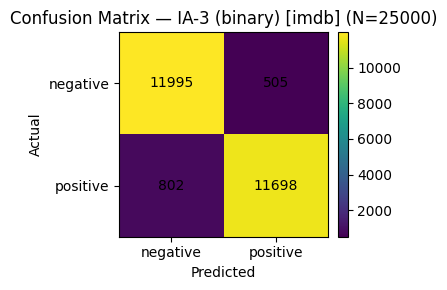


IA3_BINARY_YELP_POLARITY RESULTS

              precision    recall  f1-score   support

    negative      0.972     0.986     0.979     19000
    positive      0.985     0.971     0.978     19000

    accuracy                          0.979     38000
   macro avg      0.979     0.979     0.979     38000
weighted avg      0.979     0.979     0.979     38000


ia3_binary_yelp_polarity — Accuracy: 0.979 | Macro-F1: 0.979 | N=38000


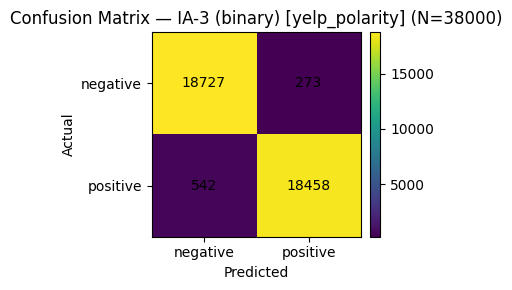


IA3_BINARY RESULTS

              precision    recall  f1-score   support

    negative      0.958     0.975     0.967     31500
    positive      0.975     0.957     0.966     31500

    accuracy                          0.966     63000
   macro avg      0.966     0.966     0.966     63000
weighted avg      0.966     0.966     0.966     63000


ia3_binary — Accuracy: 0.966 | Macro-F1: 0.966 | N=63000


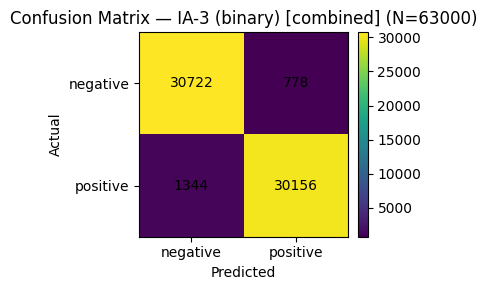

[ia3_binary] Cleaning up GPU memory...
[ia3_binary] Done.


=== IA-3 Overall (3-way + binary) ===
IA-3 (3-way)   accuracy: 0.6758  (N=15862)
IA-3 (binary)  accuracy: 0.9663  (N=63000)
Combined micro accuracy (IA-3): 0.9079  (N=78862)


In [7]:
# %% SECTION 10 — IA-3 fine-tuning (3-way + binary, per-dataset + combined)

import math
import torch
from datasets import concatenate_datasets
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig,
    pipeline,
    TrainerCallback,
)
from peft import IA3Config, get_peft_model
from google.colab import userdata

# -------------------------------------------------------------------
# 9.0  HF token + shared dict for weight memory + seed
# -------------------------------------------------------------------

hf_token = userdata.get("HF_TOKEN")
if not hf_token:
    raise RuntimeError("HF_TOKEN not set in Colab userdata.")

try:
    weight_memory_MB
except NameError:
    weight_memory_MB = {}

GLOBAL_SEED = 42
set_global_seed(GLOBAL_SEED)

IA3_SEED = GLOBAL_SEED

# -------------------------------------------------------------------
# 9.1  CONFIG: which datasets + how many examples (train + test)
# -------------------------------------------------------------------
# value:
#   None -> use ALL examples from that dataset
#   int  -> random subset of that many examples

# 3-way track (cardiff, tweeteval, sentiment140, sst5)
IA3_TRAIN3_CONFIG = {
    "cardiff":      None,
    "tweeteval":    None,
    "sentiment140": 300000,
    "sst5":         None,
}
IA3_TEST3_CONFIG = {
    "cardiff":      None,
    "tweeteval":    None,
    "sentiment140": None,
    "sst5":         None,
}

# binary track (imdb, yelp_polarity)
IA3_TRAINBIN_CONFIG = {
    "imdb":          None,
    "yelp_polarity": None,
}
IA3_TESTBIN_CONFIG = {
    "imdb":          None,
    "yelp_polarity": None,
}

# -------------------------------------------------------------------
# 9.2  Sampling helper (used for BOTH train and test)
# -------------------------------------------------------------------

def build_sampled_split(
    datasets_dict: dict,
    config: dict,
    seed: int,
    track_name: str,
):
    """
    datasets_dict : dict[name -> Dataset]
    config        : dict[name -> None or int]
    seed          : random seed for shuffling
    track_name    : label used in error messages / prints

    Returns:
      combined_split : merged Dataset
      used_info      : list of (name, n_selected, n_total)
    """
    from datasets import Dataset

    selected_splits = []
    used_info = []

    if not config:
        raise ValueError(f"[{track_name}] config dict is empty; select at least one dataset.")

    for name, max_n in config.items():
        if name not in datasets_dict:
            raise ValueError(
                f"[{track_name}] Unknown dataset '{name}'. "
                f"Available: {list(datasets_dict.keys())}"
            )

        ds = datasets_dict[name]
        assert isinstance(ds, Dataset), f"[{track_name}] '{name}' is not a Dataset."

        n_total = ds.num_rows

        if max_n is None or int(max_n) >= n_total:
            ds_sel = ds
            n_sel = n_total
        else:
            n_sel = int(max_n)
            ds_sel = ds.shuffle(seed=seed).select(range(n_sel))

        selected_splits.append(ds_sel)
        used_info.append((name, n_sel, n_total))

    if not selected_splits:
        raise ValueError(f"[{track_name}] No datasets selected after processing config.")

    combined = concatenate_datasets(selected_splits)
    return combined, used_info

# -------------------------------------------------------------------
# 9.3  IA-3 hyperparameters
# -------------------------------------------------------------------

IA3_TARGET_MODULES = [
    "q_proj", "k_proj", "v_proj", "o_proj",
    "gate_proj", "up_proj", "down_proj",
]
IA3_FEEDFORWARD_MODULES = ["gate_proj", "up_proj", "down_proj"]

IA3_LR           = 1e-4
IA3_BATCH        = 98
IA3_GRAD_ACC     = 2
IA3_EPOCHS       = 3
IA3_WEIGHT_DECAY = 0.0

IA3_MAX_LENGTH = 160

# -------------------------------------------------------------------
# 9.4  Simple progress callback (prints step/total)
# -------------------------------------------------------------------

class SimpleProgressCallback(TrainerCallback):
    def __init__(self, name: str, print_every: int = 50):
        self.name = name
        self.print_every = print_every

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step == 0 or state.max_steps is None:
            return
        if (state.global_step % self.print_every == 0) or (state.global_step == state.max_steps):
            pct = 100.0 * state.global_step / max(1, state.max_steps)
            print(f"[{self.name}] Step {state.global_step}/{state.max_steps} ({pct:.1f}%)")

# -------------------------------------------------------------------
# 9.5  Core runner
# -------------------------------------------------------------------

def run_ia3_track(
    track_name: str,               # "3way" or "binary"
    train_sets: dict,              # name -> Dataset
    test_sets: dict,               # name -> Dataset
    train_config: dict,            # which train datasets / sizes
    test_config: dict,             # which test datasets / sizes
    label_names: list[str],
    prompt_builder,                # zero_shot_prompt_3way / _binary
):
    exp_name = f"ia3_{track_name}"

    # ---- sample train -------------------------------------------------------
    print(f"\n[{exp_name}] Building TRAIN split...")
    train_comb, used_train = build_sampled_split(
        datasets_dict=train_sets,
        config=train_config,
        seed=IA3_SEED,
        track_name=f"{track_name}-train",
    )
    print(f"[{exp_name}] Train selection:")
    for name, n_sel, n_total in used_train:
        print(f"  - {name}: {n_sel} / {n_total} examples")
    print(f"[{exp_name}] TOTAL train examples: {train_comb.num_rows}")

    # ---- sample test --------------------------------------------------------
    print(f"[{exp_name}] Building TEST split...")
    test_comb, used_test = build_sampled_split(
        datasets_dict=test_sets,
        config=test_config,
        seed=IA3_SEED + 1,
        track_name=f"{track_name}-test",
    )
    eval_texts  = test_comb["text"]
    eval_labels = test_comb["label"]
    print(f"[{exp_name}] TOTAL test examples: {len(eval_texts)}")

    # ---- load tokenizer + base model ---------------------------------------
    print(f"[{exp_name}] Loading tokenizer and base model (this can take a while)...")
    tok = AutoTokenizer.from_pretrained(MODEL_ID, token=hf_token)
    base = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        device_map="auto",   # let HF auto-place across devices
        token=hf_token,
    )
    base.config.use_cache = False
    print(f"[{exp_name}] Model loaded.")

    # ---- supervised LM dataset ---------------------------------------------
    print(f"[{exp_name}] Building supervised LM dataset...")
    train_ds, pad_collate, _ = make_sup_lm_data(
        tokenizer=tok,
        ds_train=train_comb,
        label_names=label_names,
        prompt_builder=prompt_builder,
        max_length=IA3_MAX_LENGTH,
    )
    print(f"[{exp_name}] Train dataset ready: {len(train_ds)} examples.")

    # ---- attach IA-3 --------------------------------------------------------
    print(f"[{exp_name}] Attaching IA-3 adapters...")
    ia3_cfg = IA3Config(
        target_modules=IA3_TARGET_MODULES,
        feedforward_modules=IA3_FEEDFORWARD_MODULES,
        task_type="CAUSAL_LM",
    )
    model = get_peft_model(base, ia3_cfg)
    model.print_trainable_parameters()

    stats = get_model_param_stats(model)
    weight_memory_MB[exp_name] = stats["total_MB"]
    print(f"[{exp_name}] IA-3 weight memory [MB]: {stats['total_MB']:.2f}")

    # ---- training setup -----------------------------------------------------
    args = TrainingArguments(
        output_dir=f"./ft_{exp_name}_outputs",
        per_device_train_batch_size=IA3_BATCH,
        per_device_eval_batch_size=IA3_BATCH,
        gradient_accumulation_steps=IA3_GRAD_ACC,
        num_train_epochs=IA3_EPOCHS,
        learning_rate=IA3_LR,
        weight_decay=IA3_WEIGHT_DECAY,
        logging_steps=50,
        save_strategy="no",
        fp16=False,
        bf16=True,
        seed=GLOBAL_SEED,
        optim="adamw_torch",
        gradient_checkpointing=False,
        report_to=[],
        dataloader_num_workers=4,
        dataloader_pin_memory=True,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        data_collator=pad_collate,
        tokenizer=tok,
    )

    steps_per_epoch = math.ceil(len(train_ds) / (IA3_BATCH * max(1, IA3_GRAD_ACC)))
    total_steps = steps_per_epoch * IA3_EPOCHS
    print(f"[{exp_name}] Training setup: {IA3_EPOCHS} epochs, ~{total_steps} steps.")

    trainer.create_optimizer_and_scheduler(num_training_steps=total_steps)
    trainer.add_callback(SimpleProgressCallback(exp_name, print_every=50))

    # ---- train --------------------------------------------------------------
    print(f"[{exp_name}] Starting training...")
    with ResourceMonitor(f"{exp_name}_train"):
        trainer.train()
    print(f"[{exp_name}] Training finished.")

        # ---- generation pipeline -----------------------------------------------
    print(f"[{exp_name}] Preparing generation pipeline with device_map='auto'...")
    gen = pipeline(
        "text-generation",
        model=model,
        tokenizer=tok,
    )
    gen.generation_config = GenerationConfig(
        do_sample=False,
        max_new_tokens=1,
        eos_token_id=tok.eos_token_id,
        pad_token_id=tok.eos_token_id,
    )


    # ---- evaluate (all test examples) --------------------------------------
    print(f"[{exp_name}] Starting evaluation on {len(eval_texts)} examples...")
    with ResourceMonitor(f"{exp_name}_eval"):
        preds_all = predict_texts(
            gen=gen,
            texts=eval_texts,
            prompt_builder=prompt_builder,
            batch_size=128,
            show_progress=True,
        )
    print(f"[{exp_name}] Evaluation finished.")

    # ---- per-dataset reports -----------------------------------------------
    per_dataset_metrics = {}
    offset = 0
    for name, n_sel, n_total in used_test:
        start = offset
        end   = offset + n_sel
        offset = end

        y_true_ds = eval_labels[start:end]
        y_pred_ds = preds_all[start:end]

        title_ds = f"Confusion Matrix — IA-3 ({track_name}) [{name}] (N={n_sel})"
        m_ds = summarize_experiment(
            name=f"{exp_name}_{name}",
            y_true=y_true_ds,
            y_pred=y_pred_ds,
            label_names=label_names,
            weight_MB=None,
            show_cm=True,
            title=title_ds,
        )
        per_dataset_metrics[name] = m_ds

    # ---- combined report ----------------------------------------------------
    title_all = f"Confusion Matrix — IA-3 ({track_name}) [combined] (N={len(eval_labels)})"
    combined_metrics = summarize_experiment(
        name=exp_name,
        y_true=eval_labels,
        y_pred=preds_all,
        label_names=label_names,
        weight_MB=weight_memory_MB[exp_name],
        show_cm=True,
        title=title_all,
    )

    # ---- cleanup ------------------------------------------------------------
    print(f"[{exp_name}] Cleaning up GPU memory...")
    del trainer, model, base, tok, gen
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print(f"[{exp_name}] Done.\n")

    return combined_metrics, per_dataset_metrics, len(eval_labels)

# -------------------------------------------------------------------
# 9.6  Prepare train/test dicts for both tracks
# -------------------------------------------------------------------

# 3-way: train sets per dataset
train_sets_3way = {
    "cardiff":      concatenate_datasets([cardiff_train, cardiff_val]),
    "tweeteval":    concatenate_datasets([tweet_train, tweet_val]),
    "sentiment140": sent140_train,
    "sst5":         concatenate_datasets([sst5_train, sst5_val]),
}
test_sets_3way = test_sets_multiclass

# binary: train sets per dataset
train_sets_binary = {
    "imdb":          imdb_train,
    "yelp_polarity": yelp_train,
}
test_sets_bin = test_sets_binary

# -------------------------------------------------------------------
# 9.7  Run IA-3 for 3-way and binary, then combined micro-accuracy
# -------------------------------------------------------------------

ia3_3way_metrics, ia3_3way_per_ds, IA3_3WAY_N = run_ia3_track(
    track_name="3way",
    train_sets=train_sets_3way,
    test_sets=test_sets_3way,
    train_config=IA3_TRAIN3_CONFIG,
    test_config=IA3_TEST3_CONFIG,
    label_names=label_names_multiclass,
    prompt_builder=zero_shot_prompt_3way,
)

ia3_binary_metrics, ia3_binary_per_ds, IA3_BIN_N = run_ia3_track(
    track_name="binary",
    train_sets=train_sets_binary,
    test_sets=test_sets_bin,
    train_config=IA3_TRAINBIN_CONFIG,
    test_config=IA3_TESTBIN_CONFIG,
    label_names=label_names_binary,
    prompt_builder=zero_shot_prompt_binary,
)

acc_3 = ia3_3way_metrics["accuracy"]
acc_2 = ia3_binary_metrics["accuracy"]

ia3_combined_acc = (acc_3 * IA3_3WAY_N + acc_2 * IA3_BIN_N) / float(IA3_3WAY_N + IA3_BIN_N)

print("\n=== IA-3 Overall (3-way + binary) ===")
print(f"IA-3 (3-way)   accuracy: {acc_3:.4f}  (N={IA3_3WAY_N})")
print(f"IA-3 (binary)  accuracy: {acc_2:.4f}  (N={IA3_BIN_N})")
print(f"Combined micro accuracy (IA-3): {ia3_combined_acc:.4f}  (N={IA3_3WAY_N + IA3_BIN_N})")
